WIP, currently only flow model

In [1]:
#ADDITIONAL DEPENDENCIES
# #!pip install triangle
# #!pip install rasterio
# #!pip install geopy
# #!pip install osmnx

In [2]:
import sys
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from ci_adapt_classes import *
from ra2ce_multi_network.simplify_rail import *
from ra2ce_multi_network.simplify_rail import _merge_edges, _network_to_nx
import networkx as nx
import pandas as pd
from shapely import wkt, box, is_valid, make_valid
import re
from math import ceil

In [3]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

# Set paths and data sources
p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'event_data_inspection'/ 'overlapping_floods_shapefiles'

In [4]:
#FUNCTION DEFINITIONS
# Create a bounding box around the graph
def get_bbox(graph):
    min_x = min([attr['pos'][0] for _, attr in graph.nodes(data=True)])
    max_x = max([attr['pos'][0] for _, attr in graph.nodes(data=True)])
    min_y = min([attr['pos'][1] for _, attr in graph.nodes(data=True)])
    max_y = max([attr['pos'][1] for _, attr in graph.nodes(data=True)])
    
    return min_x, max_x, min_y, max_y

# Assign a weight to each edge based on the length of the edge
def set_edge_weights(assets, graph):
    # Create a dictionary to store the length of each asset
    asset_lengths = {str(asset['osm_id']): asset['geometry'].length for asset_id, asset in assets.iterrows()}

    # Loop through the edges and assign the length of the asset to the edge
    for u, v, attr in graph.edges(data=True):
        if 'source_sink' in str(u) or 'source_sink' in str(v):
            continue

        # Initialize the weight and length of the edge
        attr['weight'] = int(0)
        attr['length'] = 0
        if 'osm_id' not in attr:
            continue
        
        # For concatenated edges, split the osm_id string and sum the lengths for each asset
        osm_ids = attr['osm_id'].split('; ')
        for osm_id in osm_ids:
            if osm_id in asset_lengths:
                attr['length'] += asset_lengths[osm_id]
                attr['weight'] += int(round(asset_lengths[osm_id]*1e3,0))

    return graph

def set_edge_capacities(route_data, graph):
    # Make a copy of the graph with only the nodes identified as possible terminals
    terminal_graph = graph.copy()
    for u, attr in graph.nodes(data=True):
        if 'possible_terminal' not in graph.nodes[u]:
            continue
        if attr['possible_terminal'] == 0: 
            terminal_graph.remove_node(u)

    # Create a dictionary to store the shortest path between each OD pair
    paths={}

    # Iterate over all route ODs pairs and find the shortest path between the two nodes
    for _, attr in route_data.iterrows():
        geometry_from = wkt.loads(attr['geometry_from'])
        geometry_to = wkt.loads(attr['geometry_to'])
        
        # Snap route origin and destination geometries to nearest terminal node on graph
        if geometry_from.geom_type == 'Point':
            centroid_from = geometry_from
        else:
            centroid_from = geometry_from.centroid

        from_nearest_node = nearest_nodes(terminal_graph, centroid_from, 1)
        if geometry_to.geom_type == 'Point':
            centroid_to = geometry_to
        else:
            centroid_to = geometry_to.centroid
        to_nearest_node = nearest_nodes(terminal_graph, centroid_to, 1)

        if from_nearest_node[0][0] == to_nearest_node[0][0]:
            continue

        # Find the shortest path between the two terminals
        shortest_path = nx.shortest_path(graph, from_nearest_node[0][0], to_nearest_node[0][0], weight='weight')
        paths[(from_nearest_node[0][0], to_nearest_node[0][0])] = (shortest_path, attr['goods'])               

    # Assign the capacity of the shortest path to the edges in the graph
    for (_,_), (nodes_in_path,cap) in paths.items():
        for i in range(len(nodes_in_path)-1):
            if not graph.has_edge(nodes_in_path[i], nodes_in_path[i+1], 0):
                continue
            if nodes_in_path[i]=='source_sink' or nodes_in_path[i+1]=='source_sink':
                continue 
            if 'capacity' in graph[nodes_in_path[i]][nodes_in_path[i+1]][0]:
                graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'] = max(graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'],int(ceil(cap/52)))
            else:
                graph[nodes_in_path[i]][nodes_in_path[i+1]][0]['capacity'] = int(ceil(cap/52))
    
    # Set the capacity of edges that are not on a shortest path to the median capacity
    caps=[]
    for _, _, attr in graph.edges(data=True):
        if 'capacity' in attr:
            caps.append(attr['capacity'])
    
    median_cap = int(np.median(caps))

    for u, v, attr in graph.edges(data=True):
        if 'capacity' not in attr:
            attr['capacity'] = median_cap
        
    return graph

# Function to find the nearest node in a graph to a point
def nearest_nodes(graph, point, n):
    nearest_nodes = []
    for node, attr in graph.nodes(data=True):
        if 'geometry' in attr:
            distance = point.distance(attr['geometry'])
            nearest_nodes.append((node, distance))
    nearest_nodes = sorted(nearest_nodes, key=lambda x: x[1])

    return nearest_nodes[:n]

# Function to set the demand of each node based on the OD data
def set_node_demand(od_data, graph):
    # make a copy of the graph with only the nodes where possible_terminal is 1
    terminal_graph = graph.copy()
    for u, attr in graph.nodes(data=True):
        if attr['possible_terminal'] == 0: 
            terminal_graph.remove_node(u)

    # Loop through od_data and assign demand to the nearest terminal node
    for od in od_data.iterrows():
        if od[1]['geometry'].geom_type == 'Point':
            centroid = od[1]['geometry']
        else:
            centroid = od[1]['geometry'].centroid
        
        nearest_node = nearest_nodes(terminal_graph, centroid, 1)
        graph.nodes[nearest_node[0][0]]['demand'] += int(ceil((od[1]['demand']-od[1]['supply'])/52))
        
    return graph

# Function to make the net demand of the graph equal to zero (condition for minimum cost flow algorithm)
def equalize_demand_supply(graph):
    sumdem=0 
    # Calculate the total demand
    for u,attr in graph.nodes(data=True):
        if attr['demand'] !=0:
            sumdem+=int(attr['demand'])

    # Add a source_sink node with demand equal to negative the total demand, to make the demand and supply equal
    graph.add_node('source_sink', demand=int(-sumdem), pos=graph.nodes[0]['pos'])

    # Add edges from all nodes to the source_sink node
    for u, attr in graph.nodes(data=True):
        if u == 'source_sink':
            continue
        if not graph.has_edge(u, 'source_sink', 0):
            graph.add_edge(u,'source_sink', 0, weight=int(1e10))
        if not graph.has_edge('source_sink', u):
            graph.add_edge('source_sink', u, 0, weight=int(1e10))

    return graph

# Function to calculate the economic impact of flow disruptions
def calculate_economic_impact(delta_flow, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km):
    # Initialize the economic impact variable
    economic_impact = 0

    # Loop through the edges where there is a change in flow
    for (u,v), d_flow in delta_flow.items():
        if 'source_sink' in str(u) or 'source_sink' in str(v):
            continue
        if str(u).split('_')[0] == str(v).split('_')[0]:
            continue

        # For edges that have an increase in flow, calculate the economic impact of the disruption
        if d_flow > 0:
            # If the edge is between two dummy nodes, the cost of alternate transport mode is considered (road)
            if str(u).split('_')[-1] == 'd' and str(v).split('_')[-1] == 'd':
                economic_impact += d_flow*average_train_load_tons*(average_road_cost_per_ton_km - average_train_cost_per_ton_km)*(G_v.edges[u,v,0]['length']/1000)
            
            # If the edge is between to nodes in the main network, the cost of the train is considered
            elif type(u)==int and type(v)==int:
                print(f'd flow is positive in {u,v}')
                economic_impact += d_flow*average_train_load_tons*average_train_cost_per_ton_km*(G_v.edges[u,v,0]['length']/1000)
            else:
                print(f'Error in {u,v}')
        
        # For edges that have a decrease in flow, the cost is subtracted (since d_flow is negative)
        if d_flow < 0:
            if type(u)==int and type(v)==int:
                print(f'd flow is negative in {u,v}')
                economic_impact += d_flow*average_train_load_tons*average_train_cost_per_ton_km*(G_v.edges[u,v,0]['length']/1000)
            else:
                print(f'Error in {u,v}')

    return economic_impact


#TODO: remove if not used
def inspect_graph(graph):
    edge_capacities_types = []
    edge_weights_types = []
    node_demands_types = []

    for _, _, attr in graph.edges(data=True):
        if 'capacity' in attr:
            edge_capacities_types.append(type(attr['capacity']))
        if 'weight' in attr:
            edge_weights_types.append(type(attr['weight']))

    for _, attr in graph.nodes(data=True):
        if 'demand' in attr:
            node_demands_types.append(type(attr['demand']))

    return edge_capacities_types, edge_weights_types, node_demands_types




In [5]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = gpd.read_file(assets_path)
assets = gpd.GeoDataFrame(assets).set_crs(4326).to_crs(3857)
assets = assets.loc[assets.geometry.geom_type == 'LineString']
assets = assets.rename(columns={'railway' : 'asset'})

# #TODO: add reset index and test 
# # Drop passenger lines and light rails
# assets = assets.loc[~(assets['railway:traffic_mode'] == 'passenger')]
# assets = assets.loc[~(assets['asset'] == 'light_rail')]

# # Drop bridges and tunnels
# assets = assets.loc[~(assets['bridge'].isin(['yes']))]
# assets = assets.loc[~(assets['tunnel'].isin(['yes']))]

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

3530 assets loaded.


In [6]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #Source: Asgarpour/snkit
    # Create a railway networks with possible terminal nodes. This returns a complex network, as includes the rail tracks with the highest level of detail.
    aggregation_range = 0.08 # in km
    complex_rail_network = get_rail_network_with_terminals(network_gdf=assets, aggregation_range=aggregation_range)
    merged_rail_network = _merge_edges(network=complex_rail_network, excluded_edge_types=['bridge', 'tunnel']) #Must add network= to pass excluded_edge_types as a keyword argument

    # Number of nodes and edges reduced
    print(f"Difference in node counts: {complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0]}")
    print(f"Difference in node counts %: {round(100*(complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0])/complex_rail_network.nodes.shape[0], 0)}")
    print(f"Difference in edge counts: {complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0]}")
    print(f"Difference in edge counts %: {round(100*(complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0])/complex_rail_network.edges.shape[0], 0)}")


Difference in node counts: 746
Difference in node counts %: 19.0
Difference in edge counts: 753
Difference in edge counts %: 18.0


In [7]:
merged_rail_graph = _network_to_nx(merged_rail_network)

G=nx.MultiDiGraph(merged_rail_graph)

for _, attr in G.nodes(data=True):
    attr['demand'] = int(0)
    attr['pos'] = (attr['geometry'].x, attr['geometry'].y)

bbox_shape=box(*get_bbox(G))

In [8]:
# Set weights for flow model
G = set_edge_weights(assets, G)


In [9]:
# Load OD data
#TODO rename od_dat_2.csv to supply demand for clarity after addidng od method for capacity setting
od_data_source = r'C:\Data\interim\od_data_2.csv'
od_data = pd.read_csv(od_data_source)

# Drop rows where 'geometry' is NaN
od_data = od_data.dropna(subset=['geometry'])

# Convert 'geometry' column to shapely geometry
od_data['geometry'] = od_data['geometry'].apply(wkt.loads)

# Filter OD data to only include points within the bounding box of the graph
od_data = od_data[od_data['geometry'].apply(lambda geom: bbox_shape.contains(geom))]

In [10]:
# Set demand for flow model
G = set_node_demand(od_data, G)
G = equalize_demand_supply(G)


In [12]:
route_data_source='C:/Data/interim/route_traffic_DEU_net_seg20.csv'
route_data = pd.read_csv(route_data_source)
route_data = route_data.loc[route_data['geometry_from'].notnull()]
route_data = route_data.loc[route_data['geometry_to'].notnull()]
route_data = route_data.loc[route_data['geometry_from'] != route_data['geometry_to']]
route_data = route_data[route_data['geometry_from'].apply(lambda geom: bbox_shape.contains(wkt.loads(geom)))]
route_data = route_data[route_data['geometry_to'].apply(lambda geom: bbox_shape.contains(wkt.loads(geom)))]


In [13]:
# Set capacities for flow model
G = set_edge_capacities(route_data, G)


In [15]:

#Source: SA
max_weight_graph = max(attr['weight'] for _, _, attr in G.edges(data=True))
print('Max weight: '+str(max_weight_graph))
max_capacity_graph = max(attr['capacity'] for _, _, attr in G.edges(data=True))
print('Max capacity: '+str(max_capacity_graph))

# create a virtual node with dummy nodes
G_v=G.copy()
# convert to int
for u, v, key, attr in G.edges(keys=True, data=True):
    G_v.add_edge((str(u) + '_d'), (str(v) + '_d'), **attr)

for u in G.nodes:
    G_v.add_edge(u,(str(u) + '_d'),capacity=max_capacity_graph*100,weight=int(round(max_weight_graph-1,0)))
    G_v.add_edge((str(u) + '_d'),u,capacity=max_capacity_graph*100,weight=0)

# verify capacities, weights and demands are integers
edge_capacities_types, edge_weights_types, node_demands_types = inspect_graph(G_v)
print("Edge Capacities Types:", set(edge_capacities_types))
print("Edge Weights Types:", set(edge_weights_types))
print("Node Demands Types:", set(node_demands_types))
if {type(int())} == set(list(edge_capacities_types) + list(edge_weights_types) + list(node_demands_types)):
    print('Success: only int type values')
else: 
    print('Warning! Not all values are integers')


Max weight: 10000000000
Max capacity: 391
Edge Capacities Types: {<class 'int'>}
Edge Weights Types: {<class 'int'>}
Node Demands Types: {<class 'int'>}
Success: only int type values


In [16]:
# Solve the min cost flow problem
mcf=nx.min_cost_flow(G_v)
print('Minimum cost flow: '+str(mcf))

# Create a baseline flow dictionary
flow_dict = mcf


Minimum cost flow: {0: {2228: {0: 0}, 'source_sink': {0: 0}, '0_d': {0: 0}}, 2: {3: {0: 0}, 2252: {0: 0}, 'source_sink': {0: 0}, '2_d': {0: 0}}, 3: {2: {0: 0}, 3008: {0: 0}, 'source_sink': {0: 0}, '3_d': {0: 0}}, 4: {2385: {0: 0}, 2566: {0: 0}, 'source_sink': {0: 0}, '4_d': {0: 0}}, 5: {2385: {0: 0}, 46: {0: 0}, 58: {0: 0}, 'source_sink': {0: 0}, '5_d': {0: 0}}, 6: {7: {0: 0}, 2685: {0: 0}, 'source_sink': {0: 0}, '6_d': {0: 0}}, 7: {6: {0: 0}, 32: {0: 0}, 'source_sink': {0: 0}, '7_d': {0: 0}}, 8: {478: {0: 0}, 472: {0: 0}, 'source_sink': {0: 0}, '8_d': {0: 0}}, 10: {2386: {0: 0}, 55: {0: 0}, 334: {0: 0}, 'source_sink': {0: 0}, '10_d': {0: 0}}, 11: {2386: {0: 0}, 2567: {0: 0}, 'source_sink': {0: 0}, '11_d': {0: 0}}, 13: {2723: {0: 0}, 2722: {0: 0}, 975: {0: 0}, 'source_sink': {0: 0}, '13_d': {0: 0}}, 14: {15: {0: 0}, 16: {0: 0}, 'source_sink': {0: 0}, '14_d': {0: 0}}, 15: {14: {0: 0}, 2720: {0: 0}, 'source_sink': {0: 0}, '15_d': {0: 0}}, 16: {14: {0: 0}, 17: {0: 0}, 'source_sink': {0: 0

In [17]:
#TODO: remove after testing is finalised
max_flow = 0
for origin, destinations in flow_dict.items():
    for destination, flow in destinations.items():
        max_flow = max(max_flow, max(flow.values()))
        if len(list(flow.keys())) > 1: 
            if (flow[0] > 0) and (flow[1] > 0):
                print(f'WARNING: multiple flows from {origin} to {destination}: {flow}')
        if flow[0] > 0:
            print(f"Origin: {origin} Destination: {destination} Flow: {flow[0]}")
            if origin == 'source_sink' or destination == 'source_sink':
                print("^^^SOURCE_SINK FLOW^^^")

print('Max flow: '+str(max_flow))

Origin: 25 Destination: 1288 Flow: 20
Origin: 144 Destination: 3855 Flow: 2
Origin: 155 Destination: 3868 Flow: 24
Origin: 190 Destination: 191 Flow: 20
Origin: 191 Destination: 1314 Flow: 20
Origin: 197 Destination: 1581 Flow: 5
Origin: 198 Destination: 197 Flow: 5
Origin: 199 Destination: 688 Flow: 5
Origin: 200 Destination: 199 Flow: 5
Origin: 252 Destination: 3637 Flow: 24
Origin: 292 Destination: 294 Flow: 8
Origin: 294 Destination: 2086 Flow: 8
Origin: 317 Destination: 903 Flow: 20
Origin: 318 Destination: 317 Flow: 20
Origin: 319 Destination: 318 Flow: 20
Origin: 354 Destination: 1585 Flow: 5
Origin: 375 Destination: 144 Flow: 2
Origin: 376 Destination: 1651 Flow: 5
Origin: 377 Destination: 376 Flow: 5
Origin: 418 Destination: 419 Flow: 8
Origin: 419 Destination: 447 Flow: 8
Origin: 420 Destination: 421 Flow: 8
Origin: 421 Destination: 418 Flow: 8
Origin: 445 Destination: 446 Flow: 8
Origin: 446 Destination: 796 Flow: 8
Origin: 447 Destination: 445 Flow: 8
Origin: 449 Destinatio

In [18]:
# Function to intersect the assets with hazard polygons
def process_hazard_indirect(single_footprint, assets, interim_data_path, geom_dict):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    # load hazard map
    hazard_map = ds.read_flood_map(single_footprint)


    # convert hazard data to epsg 3857
    if '.shp' or '.geojson' in str(hazard_map):
        hazard_map=gpd.read_file(hazard_map).to_crs(3857)[['geometry']] #take only necessary columns (geometry)
    else:
        hazard_map = gpd.GeoDataFrame(hazard_map).set_crs(4326).to_crs(3857)

    # make geometries valid
    hazard_map['geometry'] = hazard_map['geometry'].apply(lambda x: make_valid(x) if not is_valid(x) else x)

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Coarse overlay of hazard map with assets...')

    # coarse overlay of hazard map with assets (filter out assets that do not overlay with hazard map)
    intersected_assets=ds.overlay_hazard_assets(hazard_map,assets)
    overlay_assets = pd.DataFrame(intersected_assets.T,columns=['asset','hazard_point'])

    # numpify hazard map
    hazard_numpified = hazard_map.to_numpy() #.drop('w_depth_u', axis=1).to_numpy()
    disrupted_asset_length = {}
    # loop through assets in the same area as hazard map and get damage per asset
    for asset in tqdm(overlay_assets.groupby('asset'),total=len(overlay_assets.asset.unique())): #group asset items for different hazard points per asset and get total number of unique assets
        # retrieve asset geometry and do fine overlay
        asset_geom = geom_dict[asset[0]]              
        # get damage per asset in a single hazard map as a dictionary of asset IDs:damage tuples
        #collect_inb[asset[0], infra_curve[0]] = tuple(ds.get_damage_per_asset(asset,h_numpified,asset_geom,hazard_intensity,fragility_values,maxdams_filt)[0] for h_numpified in hazard_numpified_list)

        # find the exact hazard overlays:
        get_hazard_points = hazard_numpified[asset[1]['hazard_point'].values] 
        get_hazard_points[shapely.intersects(get_hazard_points[0][0],asset_geom)]

        # estimate damage
        if len(get_hazard_points) == 0: # no overlay of asset with hazard
            print('length of get_hazard_points is 0')       

        else:
            if asset_geom.geom_type == 'LineString':
                overlay_meters = shapely.length(shapely.intersection(get_hazard_points[0][0],asset_geom)) # get the length of exposed meters per hazard cell
                disrupted_asset_length[asset[0]]=np.sum(overlay_meters) # sum the total length of exposed meters

    return disrupted_asset_length


# # Test the function
flood_name = 'Event_28742_DE_2011_River.shp'
test_hazard = interim_data_path / flood_name
disrupted_asset_lengths={}

disrupted_asset_lengths[flood_name]=process_hazard_indirect(test_hazard, assets, interim_data_path, geom_dict)




Flood map path: C:\Data\interim\event_data_inspection\overlapping_floods_shapefiles\Event_28742_DE_2011_River.shp
2024-05-17 16:20:26 - Coarse overlay of hazard map with assets...


In [19]:
disrupted_osm_ids=[assets.loc[asset_index]['osm_id'] for asset_index in disrupted_asset_lengths[flood_name].keys()]
disrupted_edges=[]
for u,v,attr in G.edges(data=True):
    if 'osm_id' not in attr: 
        continue
    matching_ids=[osm_id for osm_id in attr['osm_id'].split('; ') if osm_id in disrupted_osm_ids]
    if len(matching_ids)>0:
        disrupted_edges.append((u,v))

print(f'Disrupted edges: {len(disrupted_edges)}')

Disrupted edges: 1892


In [20]:
for u,v in disrupted_edges:
    G_v.edges[u,v,0]['capacity']=0

# solve the min cost flow problem
mcf=nx.min_cost_flow(G_v)
delta_flow={}
for u, vs in mcf.items():
    for v, flow in vs.items():
        d_flow = flow[0]-flow_dict[u][v][0]
        if d_flow != 0:
            delta_flow[u,v] = d_flow


In [29]:
average_train_load_tons = (896+1344+2160+1344+896+896+1344+1512+896+390)/10 # in Tons per train. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_train_cost_per_ton_km = (0.014+0.018+0.047+0.045)/4 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
# average_road_load_tons = (5.4+8.3+5.1+11.6+10.9+13.9+13.2+13.9+13.2)/9 # in Tons per truck. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_road_cost_per_ton_km = (0.395+0.375+0.246+0.203+0.138+0.153+0.125+0.103+0.122+0.099)/10 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report


impact=calculate_economic_impact(delta_flow, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
print(f'Weekly economic impact: {impact:,.2f} EUR')

d flow is negative in (25, 1288)
d flow is negative in (144, 3855)
d flow is negative in (155, 3868)
d flow is negative in (190, 191)
d flow is negative in (191, 1314)
d flow is negative in (197, 1581)
d flow is negative in (198, 197)
d flow is negative in (199, 688)
d flow is negative in (200, 199)
d flow is negative in (252, 3637)
d flow is negative in (292, 294)
d flow is negative in (294, 2086)
d flow is negative in (317, 903)
d flow is negative in (318, 317)
d flow is negative in (319, 318)
d flow is negative in (354, 1585)
d flow is negative in (375, 144)
d flow is negative in (376, 1651)
d flow is negative in (377, 376)
d flow is negative in (464, 1672)
d flow is negative in (539, 2832)
d flow is negative in (541, 539)
d flow is negative in (542, 545)
d flow is negative in (543, 542)
d flow is negative in (545, 546)
d flow is negative in (546, 1908)
d flow is negative in (548, 549)
d flow is negative in (549, 3025)
d flow is negative in (551, 552)
d flow is negative in (552, 553

Error in setting node source_sink position


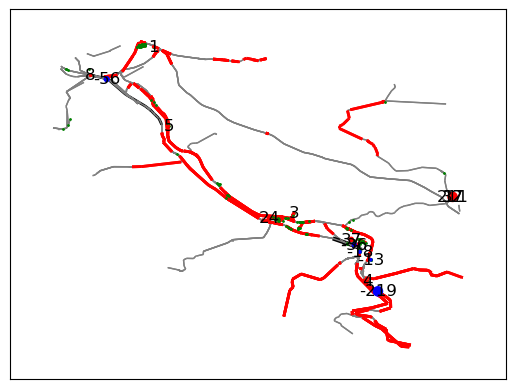

In [22]:
# Visualisation
extract_numeric_part = lambda s: int(re.search(r'\d+', s).group()) if re.search(r'\d+', s) else None

for u,attr in G_v.nodes(data=True):
    try:
        if isinstance(u, int): 
            pass
        elif isinstance(u, str): 
            if u == 'source_sink_d':
                attr['pos']=(G.nodes['source_sink']['pos'][0],G_v.nodes['source_sink']['pos'][-1])
            else:
                attr['pos']=(G_v.nodes[extract_numeric_part(u)]['pos'][0]+0.0005,G_v.nodes[extract_numeric_part(u)]['pos'][-1]+0.0005)
    except:
        print(f'Error in setting node {u} position')    
pos=nx.get_node_attributes(G_v, 'pos')
nodelist=[u for u, attr in G_v.nodes(data=True) if 'demand' in attr and attr['demand'] != 0]
edgelist=[(u, v) for u, v, attr in G.edges(data=True) if (type(u) == int and type(v) == int)]
node_size=[int(abs(ceil(attr['demand']/5))+1) for u, attr in G_v.nodes(data=True) if 'demand' in attr and attr['demand'] != 0]
width=[int(ceil(mcf[u][v][0]/10)+1) for u, v in edgelist]
node_labels={u:G_v.nodes[u]['demand'] for u in nodelist}

# draw network
nx.draw_networkx_nodes(G_v, pos, nodelist=[u for u, attr in G_v.nodes(data=True) if 'possible_terminal' in attr and attr['possible_terminal'] == 1], node_color='green', node_size=1)
nx.draw_networkx(G_v, pos,
        nodelist=nodelist,
        edgelist=edgelist,
        with_labels=True,
        labels=node_labels,
        arrows=False,
        node_size=node_size,
        node_color=['red' if attr['demand'] > 0 else 'blue' for u, attr in G_v.nodes(data=True) if 'demand' in attr and attr['demand'] != 0],
        width=width,
        edge_color=['grey' if width[i] == 1 else 'black' for i in range(len(width))])
nx.draw_networkx_edges(G_v, pos, edgelist=disrupted_edges, edge_color='red', width=2, arrows=False)



Monitoring code

In [23]:
n_sourcesink=0
n_notsourcesink=0
for u,v in G.edges(data=False):
    if not 'source_sink'in str(u) and not 'source_sink' in str(v):
        n_notsourcesink+=1
        if not (type(u)==int and type(v)==int):
            print(u,v)
    else:    
        n_sourcesink+=1     

print(f'Number of source_sink edges: {n_sourcesink}')
print(f'Number of not source_sink edges: {n_notsourcesink}')

Number of source_sink edges: 6256
Number of not source_sink edges: 7088


In [24]:
# Initialize a list to store rows
rows = []

# Iterate over the edges and add rows to the list
for i, (origin, destination, attributes) in enumerate(G_v.edges(data=True)):
    # Create a new row with the index, origin, and destination
    row = {'origin': origin, 'destination': destination}
    
    # Add each attribute as a new column
    for key, value in attributes.items():
        row['flow'] = flow_dict[origin][destination][0]
        row[key] = value
        
    

    # Append the row to the list
    rows.append(row)

# Convert the list of rows to a DataFrame
edges_df = pd.DataFrame(rows)
edges_df[edges_df['flow'] > 0].sort_values(by='flow', ascending=False).head(10)

,origin,destination,flow,osm_id,asset,name,gauge,electrified,voltage,bridge,...,_11,usage,geometry,buffered,id,from_id,to_id,length,weight,capacity
15853,source_sink,2997,211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000000000,354
6547,1782,source_sink,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000000000,354
5301,1477,3087,38,246093633,rail,None,1435,contact_line,15000,None,...,None,"""main""",LINESTRING (845267.7511150666 6511353.66125288...,"POLYGON ((845268.0302242762 6511352.38725312, ...",493.0,1477.0,3087.0,19.472957,19473,192
11018,3087,1482,38,245990895,rail,None,1435,contact_line,15000,None,...,None,None,LINESTRING (845267.7511150666 6511353.66125288...,"POLYGON ((845264.1658195164 6511368.89885908, ...",499.0,1482.0,3087.0,87.821619,87822,192
5382,1495,1501,38,246093652,rail,,1435,contact_line,15000,yes,...,,,LINESTRING (845191.1410415027 6511633.51404871...,,2911.0,1495.0,1501.0,23.673245,23673,192
5378,1494,1495,38,110754928,rail,,1435,contact_line,15000,None,...,,,LINESTRING (845204.1654219255 6511604.99247396...,,2909.0,1494.0,1495.0,31.464250,31464,192
5330,1483,1494,38,246093718,rail,Linke Rheinstrecke,1435,contact_line,15000,None,...,None,"""main""",LINESTRING (845204.1654219255 6511604.99247396...,"POLYGON ((845210.7228804482 6511592.041223715,...",500.0,1483.0,1494.0,14.516719,14517,192
5323,1482,1483,38,110748411,rail,None,1435,contact_line,15000,None,...,None,None,LINESTRING (845252.0661988138 6511440.02659040...,"POLYGON ((845247.6459959549 6511466.993990448,...",498.0,1482.0,1483.0,158.322441,158322,192
11149,3127,1517,38,842846320; 260698080,rail; rail,Linke Rheinstrecke; Linke Rheinstrecke,1435; 1435,contact_line; contact_line,15000; 15000,None; None,...,,"""main""; ""main""",LINESTRING (843585.0345602863 6512780.67247651...,,3476.0,1517.0,3127.0,111.461412,111461,192
5412,1501,1471,38,110754939,rail,,1435,contact_line,15000,None,...,,,LINESTRING (845181.4117180074 6511655.07111807...,,2910.0,1471.0,1501.0,32.319719,32320,192
